In [0]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# !pip install tqdm

--2020-03-17 09:43:16--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-03-17 09:43:16--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-03-17 09:43:16--  https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving iweb.dl.sourceforge.ne

In [0]:
import pandas_datareader as web
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import talib
import torch
import random
from tqdm import tqdm
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
STATNN_EPOCH = 100
BATCH_NUM = 10
BATCH_SIZE = 16
LR = 1e-3
STATE_FEATURE_NUM = 64
GAMMA = 0.90
EPISILO = 0.9
NUM_ACTIONS = 3
MEMORY_CAPACITY = 100
TARGET_TRAIN_ITERATION = 30
ACTION_SPACE = ["Hold", "Buy", "Sell"]
TICKER_LIST = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "XOM",
               "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE",
               "PFE", "PG", "TRV", "UNH", "UTX", "VZ", "V", "WMT", "WBA", "DIS"]

In [0]:
def get_DAJA(ticker_list, start_date="2015-01-01", end_date="2020-01-01"):
    print("-------------downloading data------------")
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    # end_date = np.datetime64(end_date)
    all_close = []
    all_open = []
    all_high = []
    all_low = []
    all_volume = []
    for ticker in ticker_list:
        data = web.get_data_yahoo(ticker, start_date, end_date)
        all_close.append(data["Close"])
        all_open.append(data["Open"])
        all_high.append(data["High"])
        all_low.append(data["Low"])

    djia_close = pd.concat(all_close, axis=1)
    djia_open = pd.concat(all_open, axis=1)
    djia_high = pd.concat(all_high, axis=1)
    djia_low = pd.concat(all_low, axis=1)

    djia_close.dropna(inplace=True)
    djia_open.dropna(inplace=True)
    djia_high.dropna(inplace=True)
    djia_low.dropna(inplace=True)
    
    djia_close.columns = ticker_list
    djia_open.columns = ticker_list
    djia_high.columns = ticker_list
    djia_low.columns = ticker_list

    return djia_close, djia_open, djia_high, djia_low

In [0]:
def normalized_data(input, min_max_scaler, inverse=False):
    if inverse:
        input = input.reshape(-1, 1)
        inverse_input = min_max_scaler.inverse_transform(input)
        inverse_input = inverse_input.squeeze()
        return inverse_input
    else:
        x = input.values  # returns a numpy array
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        x_scaled = min_max_scaler.fit_transform(x)
        df = pd.DataFrame(x_scaled, index=input.index)
        if type(input) == pd.DataFrame:
            df.columns = TICKER_LIST
        return df

In [0]:
def inverse_normalized(input):
    min_max_scaler = preprocessing.MinMaxScaler()
    inverse_input = min_max_scaler.fit_transform(input)
    return inverse_input

In [0]:
def elbow(return_volatility):
    distortions = []
    K = range(1, len(TICKER_LIST))
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(return_volatility)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [0]:
def get_ret_vlt(price, price_norm):
    ret_vlt = pd.DataFrame(index=TICKER_LIST)
    ret = []
    vlt = []

    for ticker in TICKER_LIST:
        ret.append(np.sum(price[ticker].pct_change().iloc[1:]))
        vlt.append(np.std(price_norm[ticker]))

    ret_vlt["returns"] = ret
    ret_vlt["volatility"] = vlt
    return ret_vlt

In [0]:
def draw_efficient_frontier(select_price, select_price_norm, ret_vlt):
    print("--------drawing efficient forntier-----------")
    start_time = datetime.now()
    np.random.seed(42)
    num_ports = 60000
    all_weights = np.zeros((num_ports, len(select_price.columns)))
    ret_arr = np.zeros(num_ports)
    vlt_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    for x in range(num_ports):
        # Weights
        weights = np.array(np.random.random(3))
        weights = weights / np.sum(weights)

        # Save weights
        all_weights[x, :] = weights
        # Expected return
        ret_arr[x] = np.sum(np.sum(select_price.pct_change().iloc[1:] * weights))

        # Expected volatility
        vlt_arr[x] = np.sqrt(np.dot(weights.T, np.dot(select_price_norm.cov(), weights)))

        # Sharpe Ratio
        sharpe_arr[x] = (ret_arr[x] - 0.0156) / vlt_arr[x]

    print("the max sharpe ratio", sharpe_arr.max())
    print("the index of max sharpe ratio", sharpe_arr.argmax())

    print("the weights of max sharpe ratio", all_weights[sharpe_arr.argmax()])

    max_ret = ret_arr[sharpe_arr.argmax()]
    max_vol = vlt_arr[sharpe_arr.argmax()]
    plt.figure(figsize=(12, 8))
    plt.scatter(vlt_arr, ret_arr, c=sharpe_arr, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(max_vol, max_ret, c='red', s=200)  # red dot
    for ticker in ["MRK", "AAPL", "DIS"]:
        plt.scatter(ret_vlt["volatility"].loc[ticker], ret_vlt["returns"].loc[ticker], c="black", s=200)
    plt.show()
    return all_weights[sharpe_arr.argmax()]

In [0]:
def construct_x(open_price, close_price, high_price, low_price, min_max_scaler, norm=True):
  open_price_norm = normalized_data(open_price, min_max_scaler)
  high_price_norm = normalized_data(high_price, min_max_scaler)
  low_price_norm = normalized_data(low_price, min_max_scaler)
  close_price_norm = normalized_data(close_price, min_max_scaler)
  rsi = talib.RSI(close_price)
  upperband, middleband, lowerband = talib.BBANDS(close_price, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
  macd, macdsignal, macdhist = talib.MACD(close_price, fastperiod=12, slowperiod=26, signalperiod=9)
  if norm:
    df = pd.concat([open_price_norm, close_price_norm, high_price_norm, low_price_norm, rsi, upperband, middleband,
                    lowerband, macd, macdsignal, macdhist], axis=1)
  else:
    df = pd.concat([open_price, close_price, high_price, low_price, rsi, upperband, middleband,
                    lowerband, macd, macdsignal, macdhist], axis=1)
  df.columns = ["Open", "Close", "High", "Low", "RSI", "Upper", "Middle", "Lower", "Macd", "MacdSignal", "MacdHist"]
  df.dropna(inplace=True)

  return df

In [0]:
def construct_dataset(x_df, train_ratio=0.7):
    x_train_dataset = []
    y_train_dataset = []
    x_test_dataset = []
    y_test_dataset = []
    for i in range(len(x_df) - 1):
        if i >= int(train_ratio * len(x_df)):
            x_test_dataset.append(torch.tensor(x_df.iloc[i]))
            y_test_dataset.append(torch.tensor(x_df["Close"].iloc[i + 1]))
        else:
            x_train_dataset.append(torch.tensor(x_df.iloc[i]))
            y_train_dataset.append(torch.tensor(x_df["Close"].iloc[i + 1]))
    x_train_dataset = torch.stack(x_train_dataset, dim=0)
    y_train_dataset = torch.stack(y_train_dataset, dim=0)
    x_test_dataset = torch.stack(x_test_dataset, dim=0)
    y_test_dataset = torch.stack(y_test_dataset, dim=0)
    return x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset

In [0]:
def construct_batch(x_dataset, y_dataset, batch_size=BATCH_SIZE, batch_num=BATCH_NUM, train=True):
    if not train:
        return x_dataset.unsqueeze(0), y_dataset.unsqueeze(0)
    else:
        data_len = x_dataset.shape[0]
        seq_len = int(data_len / 2)
        existed_index = []
        all_batch = []
        for _ in range(batch_num):
            batch_x = []
            batch_y = []
            for _ in range(batch_size):
                start_index = np.random.randint(0, data_len - seq_len)
                while start_index in existed_index:
                    start_index = np.random.randint(0, data_len - seq_len)
                existed_index.append(start_index)

                batch_x.append(x_dataset[start_index:start_index + seq_len])
                batch_y.append(y_dataset[start_index:start_index + seq_len])
            batch_x = torch.stack(batch_x)
            batch_y = torch.stack(batch_y)
            all_batch.append((batch_x, batch_y))
    return all_batch

-------------downloading data------------


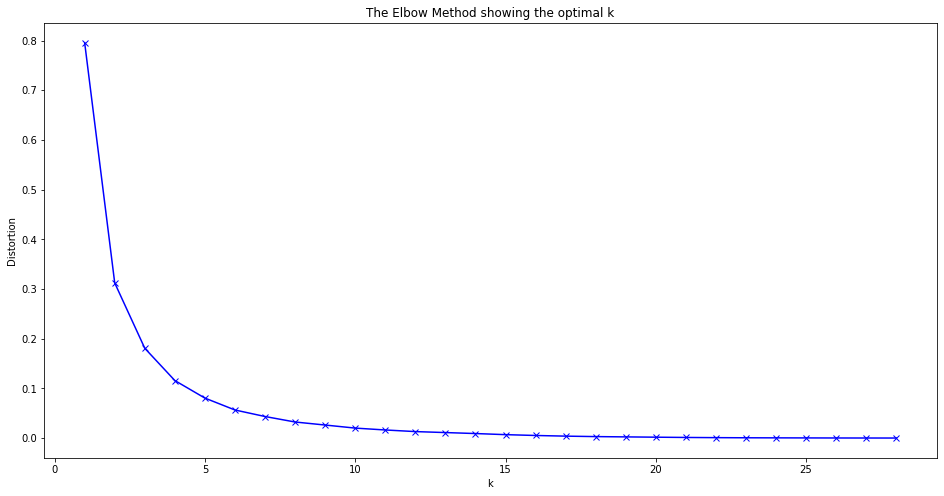

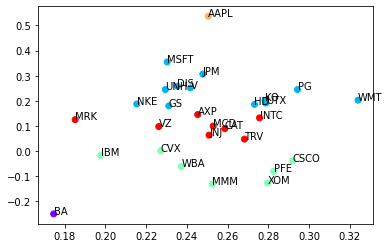

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
# construct optimized portfolio
djia_close, djia_open, djia_high, djia_low = get_DAJA(ticker_list=TICKER_LIST, start_date="2019-03-03", end_date="2020-01-01")
djia_close_norm = normalized_data(djia_close, min_max_scaler)
ret_vlt = get_ret_vlt(djia_close, djia_close_norm)
elbow(ret_vlt)
kmeans = KMeans(n_clusters=5).fit(ret_vlt)
centroids = kmeans.cluster_centers_
plt.scatter(ret_vlt["volatility"], ret_vlt["returns"], c=kmeans.labels_, cmap="rainbow")
for ticker in TICKER_LIST:
    plt.text(ret_vlt.loc[ticker][1], ret_vlt.loc[ticker][0], ticker)
plt.show()

--------drawing efficient forntier-----------
the max sharpe ratio 1.8096727588261285
the index of max sharpe ratio 25141
the weights of max sharpe ratio [1.41087656e-04 5.44860107e-01 4.54998805e-01]


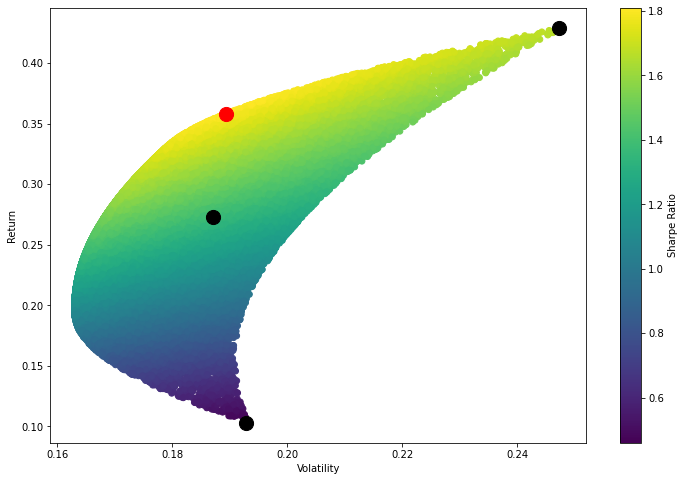

-------------downloading data------------


In [0]:
selected_ticker = ["MRK", "AAPL", "DIS"]
select_close_df = djia_close[selected_ticker]
selected_close_df_norm = djia_close_norm[selected_ticker]
weights = draw_efficient_frontier(select_close_df, selected_close_df_norm, ret_vlt)
djia_close, djia_open, djia_high, djia_low = get_DAJA(ticker_list=selected_ticker, start_date="2015-01-01", end_date="2020-01-01")

In [0]:
select_close_df = djia_close[selected_ticker]
select_close_df = select_close_df * weights
close_price = select_close_df.sum(axis=1)

select_open_df = djia_open[selected_ticker]
select_open_df = select_open_df * weights
open_price = select_open_df.sum(axis=1)

select_high_df = djia_high[selected_ticker]
select_high_df = select_high_df * weights
high_price = select_high_df.sum(axis=1)

select_low_df = djia_low[selected_ticker]
select_low_df = select_low_df * weights
low_price = select_low_df.sum(axis=1)

In [0]:
 # build dataset
x_df = construct_x(open_price, close_price, high_price, low_price, min_max_scaler, norm=False)
x_norm_df = construct_x(open_price, close_price, high_price, low_price, min_max_scaler, norm=True)
x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset = construct_dataset(x_norm_df)
all_train_batch = construct_batch(x_train_dataset, y_train_dataset)
all_test_batch = construct_batch(x_test_dataset, y_test_dataset, train=False)

In [0]:
class StateNN(nn.Module):
    def __init__(self, feature_num, num_layer=2):
        super(StateNN, self).__init__()
        self.num_layer = num_layer
        self.embedding = nn.Linear(feature_num,64)
        self.lstm = nn.LSTM(64, 128, num_layer, dropout=0.2)
        self.linear1 = nn.Linear(128, 64)
        self.linear2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        self.ws1 = nn.Linear(128, 64, bias=False)
        self.ws2 = nn.Linear(64, 1, bias=False)

    def init_weights(self, init_range=0.1):
        self.ws1.weight.data.uniform_(-init_range, init_range)
        self.ws2.weight.data.uniform_(-init_range, init_range)
        
    def forward(self, x, h0=None, c0=None):
        """

        :param x: shape N,  Lin, Cin,
        :return:
        """
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # convert to Lin, N, Cin
        if h0 is None:
            h0 = torch.zeros(self.num_layer, x.shape[1], 128)
        if c0 is None:
            c0 = torch.zeros(self.num_layer, x.shape[1], 128)

        output, (hn, cn) = self.lstm(x, (h0, c0))  # output_shape = seq_len, N, 128, hn=num_layer,1,128
        
        # add self-Attention in LSTM
        output = output.permute(1, 0, 2)  # N, seq_len, output_size
        att_output = []
        att_output.append(output[:,0,:].unsqueeze(1))
        for i in range(1, output.shape[1]):
          part_output = output[:,:i,:]
          A = self.softmax(self.ws2(self.tanh(self.ws1(part_output)))) # N*seq_len*4
          A = A.permute(0,2,1) #N, 1, seq
          m = torch.bmm(A,part_output) # N, 1, output_size
          att_output.append(m)
        att_output = torch.stack(att_output,1)
        att_output = self.linear1(att_output)
        current_state = att_output[:, -1, :]  # N, 1, 64 
        current_state = torch.squeeze(current_state)
        all_state = att_output
        att_output = self.linear2(att_output)  # N, seq_len, 1
        output = output.squeeze()
        att_output = self.sigmoid(att_output)
        att_output=att_output.squeeze()
        return att_output, hn, cn, all_state, current_state

In [0]:
# train statnn
state_nn = StateNN(feature_num=x_train_dataset.shape[1])
if torch.cuda.is_available():
  state_nn = state_nn.to(device)
mse_loss = torch.nn.MSELoss(reduction="mean")
stat_optimizer = torch.optim.Adam(state_nn.parameters(), lr=1e-3)

In [0]:
train_loss = []
test_loss = []
for epoch in tqdm(range(STATNN_EPOCH)):
  state_nn.train()
  # shuffle batch
  random.shuffle(all_train_batch)
  total_loss = 0
  for batch_x, batch_y in tqdm(all_train_batch):
    stat_optimizer.zero_grad()
    if torch.cuda.is_available():
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
    output, _, _, _, _ = state_nn(batch_x)
    statnn_loss = mse_loss(output, batch_y)
    statnn_loss.backward()
    stat_optimizer.step()
    total_loss += statnn_loss.detach()
  total_loss /= len(all_train_batch)
  print("epoch: {} , the epoch loss is {}".format(epoch, total_loss))
  train_loss.append(total_loss)

  with torch.no_grad():
      state_nn.eval()
      x_test_dataset, y_test_dataset = all_test_batch
      if torch.cuda.is_available():
        x_test_dataset = x_test_dataset.cuda()
        y_test_dataset = y_test_dataset.cuda()
      test_output, _, _, _, _ = state_nn(x_test_dataset)
      y_test_dataset = y_test_dataset[:, :len(test_output)]
      test_output = test_output.unsqueeze(0)
      test_state_nn_loss = mse_loss(test_output, y_test_dataset)
      print("Test: epoch: {} , the epoch loss is {}".format(epoch, test_state_nn_loss))
      test_loss.append(test_state_nn_loss)

  # draw prediction result and save parameters
  if (epoch + 1) % 20 == 0:
      torch.save(state_nn.state_dict(), "state_nn_{}".format(epoch))
      files.download("state_nn_{}".format(epoch))
      pre_fig = go.Figure()
      pre = test_output.squeeze().numpy()
      real = y_test_dataset.squeeze().numpy()
      x_axis = len(test_output)
      result_fig = go.Figure()
      x_axis = [i for i in range(len(pre))]
      result_fig.add_trace(
          go.Scatter(x=x_axis, y=normalized_data(pre, min_max_scaler, inverse=True), mode="lines",
                      name="prediction"))
      result_fig.add_trace(
          go.Scatter(x=x_axis, y=normalized_data(real, min_max_scaler, inverse=True), mode="lines", name="real"))
      result_fig.show()

  # draw loss fig

loss_fig = go.Figure()
x_axis = [i for i in range(STATNN_EPOCH)]
loss_fig.add_trace(go.Scatter(x=x_axis, y=train_loss,mode="lines", name="train_loss"))
loss_fig.add_trace(go.Scatter(x=x_axis, y=test_loss,mode="lines", name="test_loss"))
loss_fig.show()

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 , the epoch loss is 0.04364209994673729
Test: epoch: 0 , the epoch loss is 0.2626765966415405



 40%|████      | 4/10 [00:24<00:36,  6.11s/it]

KeyboardInterrupt: ignored

In [0]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -(torch.log(-torch.log(U + eps) + eps))


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [0]:
class Stock:
    def __init__(self, x_df, all_state, init_money=1000000):
        self.stock = x_df
        self.all_state = all_state
        self.init_money = init_money
        self.balance = init_money
        self.hold_num = 0
        self.reward = 0
        self.buy_point = []
        self.sell_point = []

    def get_state(self, t):
        return self.all_state[t]

    def reset(self):
        self.balance = self.init_money
        self.hold_num = 0
        self.reward = 0
        self.buy_point = []
        self.sell_point = []
        return self.get_state(0)

    def step(self, action, t):
        """

        :param action: 0 hold, 1 buy, 2 sell
        :param open_price
        :return:
        """

        if action == 0:
            self.reward = self.stock["Close"].iloc[t + 1] - self.stock["Close"].iloc[t]

        elif action == 1:
            # at least buy a round lot
            if self.balance > (self.stock["Open"].iloc[t + 1] * 100):
                num_round_lot = int(self.balance / (self.stock["Open"].iloc[t + 1] * 100))
                self.balance -= self.stock["Open"].iloc[t + 1] * 100 * num_round_lot
                self.hold_num += num_round_lot * 100
                self.reward = self.stock["Close"].iloc[t + 1] - self.stock["Open"].iloc[t]
                self.buy_point.append(t)

        elif action == 2:
            # at least has stock to sell
            if self.hold_num != 0:
                self.balance += self.hold_num * self.stock["Open"].iloc[t + 1]
                self.hold_num = 0
                self.reward = self.stock["Open"].iloc[t + 1] - self.stock["Close"].iloc[t + 1]
                self.sell_point.append(t)

        state = self.get_state(t)
        next_state = self.get_state(t + 1)
        done = False
        if t == len(self.all_state) - 2:
            done = True
        return state, action, self.reward, next_state, done

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(STATE_FEATURE_NUM, 128)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(128, 256)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(256, 128)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(128, 64)
        self.fc4.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(64, 3)
        self.out.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        action_value = self.out(x)
        return action_value

In [0]:
class DQN():
    """docstring for DQN"""

    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((MEMORY_CAPACITY, 64 * 2 + 2))
        # why the NUM_STATE*2 +2
        # When we store the memory, we put the state, action, reward and next_state in the memory
        # here reward and action is a number, state is a ndarray
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.mse_loss = nn.MSELoss()

    def choose_action(self, state):
        state = torch.unsqueeze(state, 0)  # get a 1D array
        if np.random.randn() <= EPISILO:  # greedy policy
            action_value = self.eval_net.forward(state)
            action = torch.argmax(gumbel_softmax(action_value, 0.01))

        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):

        # update the parameters
        if self.learn_step_counter % TARGET_TRAIN_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :STATE_FEATURE_NUM])
        batch_action = torch.LongTensor(batch_memory[:, STATE_FEATURE_NUM:STATE_FEATURE_NUM + 1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, STATE_FEATURE_NUM + 1:STATE_FEATURE_NUM + 2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -STATE_FEATURE_NUM:])

        # q_eval
        q_eval = self.eval_net(batch_state)
        q_next = self.target_net(batch_next_state).detach()
        batch_index = np.arange(BATCH_SIZE, dtype=np.int32)
        max_, _ = torch.max(q_next, dim=1)
        q_target = q_eval.clone()
        q_target[batch_index, batch_action] = batch_reward + GAMMA * max_
        loss = self.mse_loss(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


torch.Size([1, 857, 11])
                  Open       Close        High  ...      Macd  MacdSignal  MacdHist
Date                                            ...                                
2015-02-20  154.509996  155.557001  155.601601  ...  5.992702    5.337767  0.654935
2015-02-23  156.114805  159.012999  159.092401  ...  6.247078    5.519629  0.727449
2015-02-24  158.824803  158.129698  159.606407  ...  6.304721    5.676648  0.628074
2015-02-25  157.555198  155.191294  157.993407  ...  6.043632    5.750044  0.293587
2015-02-26  155.173694  156.446198  157.222495  ...  5.870308    5.774097  0.096211
...                ...         ...         ...  ...       ...         ...       ...
2019-12-24  315.662303  315.472288  316.109112  ...  6.579001    6.229415  0.349586
2019-12-26  316.031005  320.951302  321.073411  ...  7.015530    6.386638  0.628892
2019-12-27  322.212596  320.864988  325.058499  ...  7.270705    6.563452  0.707254
2019-12-30  320.542592  321.895591  323.650301  ...

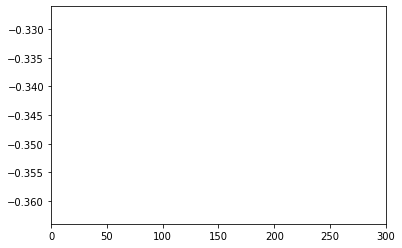

In [0]:
with torch.no_grad():
    state_nn.eval()
    x_train_dataset = x_train_dataset.squeeze()
    x_train_dataset = x_train_dataset.unsqueeze(0)
    _,_,_,all_state,_ = state_nn(x_train_dataset)
    
all_state = all_state.squeeze()  # seq_len, feature_num
dqn = DQN()
env = Stock(x_df, all_state)
episodes = 400
print("Collecting Experience....")
reward_list = []

fig, ax = plt.subplots()
for i in range(episodes):
  print("------episodes{}-------".format(i))
  state = env.reset()
  ep_reward = 0
  for t in range(len(all_state) - 1):

      action = dqn.choose_action(all_state[t])
      state, action, reward, next_state, done = env.step(action, t)
      dqn.store_transition(state, action, reward, next_state)
      ep_reward += reward
      if dqn.memory_counter >= MEMORY_CAPACITY:
          dqn.learn()
          if done:
              print("episode: {} ,time: {},  the episode reward is {}".format(i, t, round(ep_reward, 3)))
      if done:
          break
      state = next_state

reward_list.append(reward)
ax.set_xlim(0, 300)
# ax.cla()
ax.plot(reward_list, 'g-', label='total_loss')
plt.show()
plt.pause(0.001)